# Functions for preprocessing data

Here we define the functions utilized for preprocessing the data we are presented with. 
First, we will specify the folder where the data exists, and the wewill determine whether we want a stock or an ETF, and the name of the stoc or ETF. From there, we will import the data and start pre-processing it. Then, once it has been properly processed, we will return the split testing and training data for use in implementing.



## Pseudo-Code

1) get filepath
2) get stock type (ETF or Stock)
3) get stock name
4) load data
5) sort data by date
6) delete OpenInt column
7) standardize volume
8) get daily market deltas (open-close, high-low)
9) get near-end-of-quarter data
10) split data into testing and training sets

In [11]:
#Import Libraries
import os # operating system module
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization and plotting
import seaborn as sns # statistical plotting
from datetime import datetime # Convert Datetime 
from sklearn.model_selection import TimeSeriesSplit, train_test_split # for linear model
from sklearn.preprocessing import StandardScaler #for scaling data


In [8]:
# Input Filepath
f = "C:\\Users\\Spenc\\Desktop\\jupyter_notebook\\Project\\Data\\archive" #do not include \\ at the end or this will not work
os.chdir(f)
print(f"The current path for your notebook is:\n {os.getcwd()} \n")
print(f"Your notebook is currently in the following directory:\n {os.path.basename(os.getcwd())}")

The current path for your notebook is:
 C:\Users\Spenc\Desktop\jupyter_notebook\Project\Data\archive 

Your notebook is currently in the following directory:
 archive


In [61]:
# Input stock type

# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 

In [104]:
def get_data(f,st,sn):
    
    full_fp = (f + "\\" + st + "\\" + sn + ".us.txt")
    df = pd.read_csv(full_fp)
    
    return df





def del_OI(df_sorted):

    df_dropped = df_sorted.drop(labels=["OpenInt"], axis=1)
    
    return df_dropped






def std_vol(df_dropped):
    
    scaled_features = df_dropped.copy()
    col_names = ['Volume']
    features = scaled_features[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_features[col_names] = features
    
    
    df_scaled = scaled_features
    
    return df_scaled




def get_daily_deltas(df_scaled):

    df_scaled["High-Low"] = df_scaled["High"] - df_scaled["Low"]
    df_scaled["Close-Open"] = df_scaled["Close"] - df_scaled["Open"]

    return df_scaled




def nearendquarter(month,day):

    if month in [3, 6, 9, 12]:
        if month in [3, 12]:
            if day in [31, 30, 29, 28, 27, 26, 25]:
                return 1
            else:
                return 0
        else:
            if day in [30, 29, 28, 27, 26, 25, 24]:
                return 1
            else: 
                return 0
    else:
        return 0





def convertdatetime(s):
    
    date = pd.to_datetime(s)

    return date




def converttoday(dt):

    dt =  dt.weekday()

    return dt


def near_end_quart(df_added):

    splitted = df_added['Date'].str.split('-', expand=True)
 
    df_added['Day_date'] = splitted[2].astype('int')
    df_added['Month'] = splitted[1].astype('int')
    df_added['Year'] = splitted[0].astype('int')

    
    df_added['near_end_quarter'] = df_added.apply(lambda x: \
        nearendquarter(x['Month'], x['Day_date']), axis=1)
    
    
    #convert Date to datetime in order to day the day of the week
    df_added['Date'] = df_added['Date'].apply(convertdatetime)
    df_added['Day'] = df_added['Date'].apply(converttoday)

    #reindex by the date so it can be split into time series data later
    df_added.set_index('Date',inplace=True)
    df_added.sort_index(inplace=True)

    return df_added





def split_data(df_end_quart):

    X = df_end_quart.drop(labels=["Close"], axis=1)
    T = df_end_quart["Close"]

    tss = TimeSeriesSplit(n_splits = 2)

    for train_indx, test_indx in tss.split(X):
    
        X_train, X_test = X.iloc[train_indx, :], X.iloc[test_indx,:]
        T_train, T_test = T.iloc[train_indx], T.iloc[test_indx] 

    return X_train, X_test, T_train, T_test







def  market_prepro(f,st,sn):
    df = get_data(f,st,sn) #get the dataset imported 
    df_dropped = del_OI(df)
    df_scaled = std_vol(df_dropped)
    df_added = get_daily_deltas(df_scaled)
    df_end_quart = near_end_quart(df_added)
    X_train, X_test, T_train, T_test = split_data(df_end_quart)

    display(df_end_quart.head())
    df_end_quart.info()
    display(df_end_quart.describe())
    display("The start date of the training data is ", (X_train[:1]))
    display("The last date of the training data is ", (X_train[-1:]))
    display("The start date of the training data is ", (X_test[:1]))
    display("The last date of the training data is ", (X_test[-1:]))

    sns.heatmap(df_end_quart.corr(),annot=True, square=True, cmap='terrain', linewidths=0.1)
    sns.pairplot(df_end_quart)

    return X_train, X_test, T_train, T_test

,Open,High,Low,Close,Volume,High-Low,Close-Open,Day_date,Month,Year,near_end_quarter,Day
Date,,,,,,,,,,,,
2010-07-21,24.333,24.333,23.946,23.946,3.061301,0.387,-0.387,21,7,2010,0,2
2010-07-22,24.644,24.644,24.362,24.487,0.961370,0.282,-0.157,22,7,2010,0,3
2010-07-23,24.759,24.759,24.314,24.507,0.202937,0.445,-0.252,23,7,2010,0,4
2010-07-26,24.624,24.624,24.449,24.595,1.078614,0.175,-0.029,26,7,2010,0,0
2010-07-27,24.477,24.517,24.431,24.517,0.166319,0.086,0.040,27,7,2010,0,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1565 entries, 2010-07-21 to 2017-11-10
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1565 non-null   float64
 1   High              1565 non-null   float64
 2   Low               1565 non-null   float64
 3   Close             1565 non-null   float64
 4   Volume            1565 non-null   float64
 5   High-Low          1565 non-null   float64
 6   Close-Open        1565 non-null   float64
 7   Day_date          1565 non-null   int32  
 8   Month             1565 non-null   int32  
 9   Year              1565 non-null   int32  
 10  near_end_quarter  1565 non-null   int64  
 11  Day               1565 non-null   int64  
dtypes: float64(7), int32(3), int64(2)
memory usage: 140.6 KB


,Open,High,Low,Close,Volume,High-Low,Close-Open,Day_date,Month,Year,near_end_quarter,Day
count,1565.000000,1565.000000,1565.000000,1565.000000,1.565000e+03,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000
mean,36.014550,36.137120,35.855319,35.987517,4.094701e-16,0.281801,-0.027034,15.834505,6.677316,2013.872843,0.077955,2.017891
std,6.957747,7.002548,6.878264,6.933814,1.000320e+00,0.353115,0.301219,8.804721,3.441142,2.185996,0.268187,1.393146
min,23.936000,23.946000,23.867000,23.946000,-5.356510e-01,0.000000,-2.691000,1.000000,1.000000,2010.000000,0.000000,0.000000
25%,29.829000,29.966000,29.819000,29.862000,-4.918920e-01,0.039000,-0.115000,8.000000,4.000000,2012.000000,0.000000,1.000000
50%,36.512000,36.571000,36.322000,36.464000,-4.063670e-01,0.200000,0.000000,16.000000,7.000000,2014.000000,0.000000,2.000000
75%,38.957000,39.123000,38.787000,38.838000,-3.819397e-02,0.389000,0.085000,23.000000,10.000000,2016.000000,0.000000,3.000000
max,58.620000,58.720000,57.700000,58.430000,8.277334e+00,4.362000,1.697000,31.000000,12.000000,2017.000000,1.000000,4.000000


'The start date of the training data is '

,Open,High,Low,Volume,High-Low,Close-Open,Day_date,Month,Year,near_end_quarter,Day
Date,,,,,,,,,,,
2010-07-21,24.333,24.333,23.946,3.061301,0.387,-0.387,21,7,2010,0,2


'The last date of the training data is '

,Open,High,Low,Volume,High-Low,Close-Open,Day_date,Month,Year,near_end_quarter,Day
Date,,,,,,,,,,,
2015-09-14,35.938,35.938,35.938,-0.527431,0.0,0.0,14,9,2015,0,0


'The start date of the training data is '

,Open,High,Low,Volume,High-Low,Close-Open,Day_date,Month,Year,near_end_quarter,Day
Date,,,,,,,,,,,
2015-09-15,35.938,35.938,35.938,-0.527431,0.0,0.0,15,9,2015,0,1


'The last date of the training data is '

,Open,High,Low,Volume,High-Low,Close-Open,Day_date,Month,Year,near_end_quarter,Day
Date,,,,,,,,,,,
2017-11-10,56.96,56.96,56.3909,1.891517,0.5691,-0.56,10,11,2017,0,4


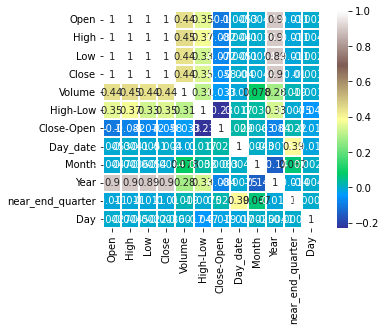

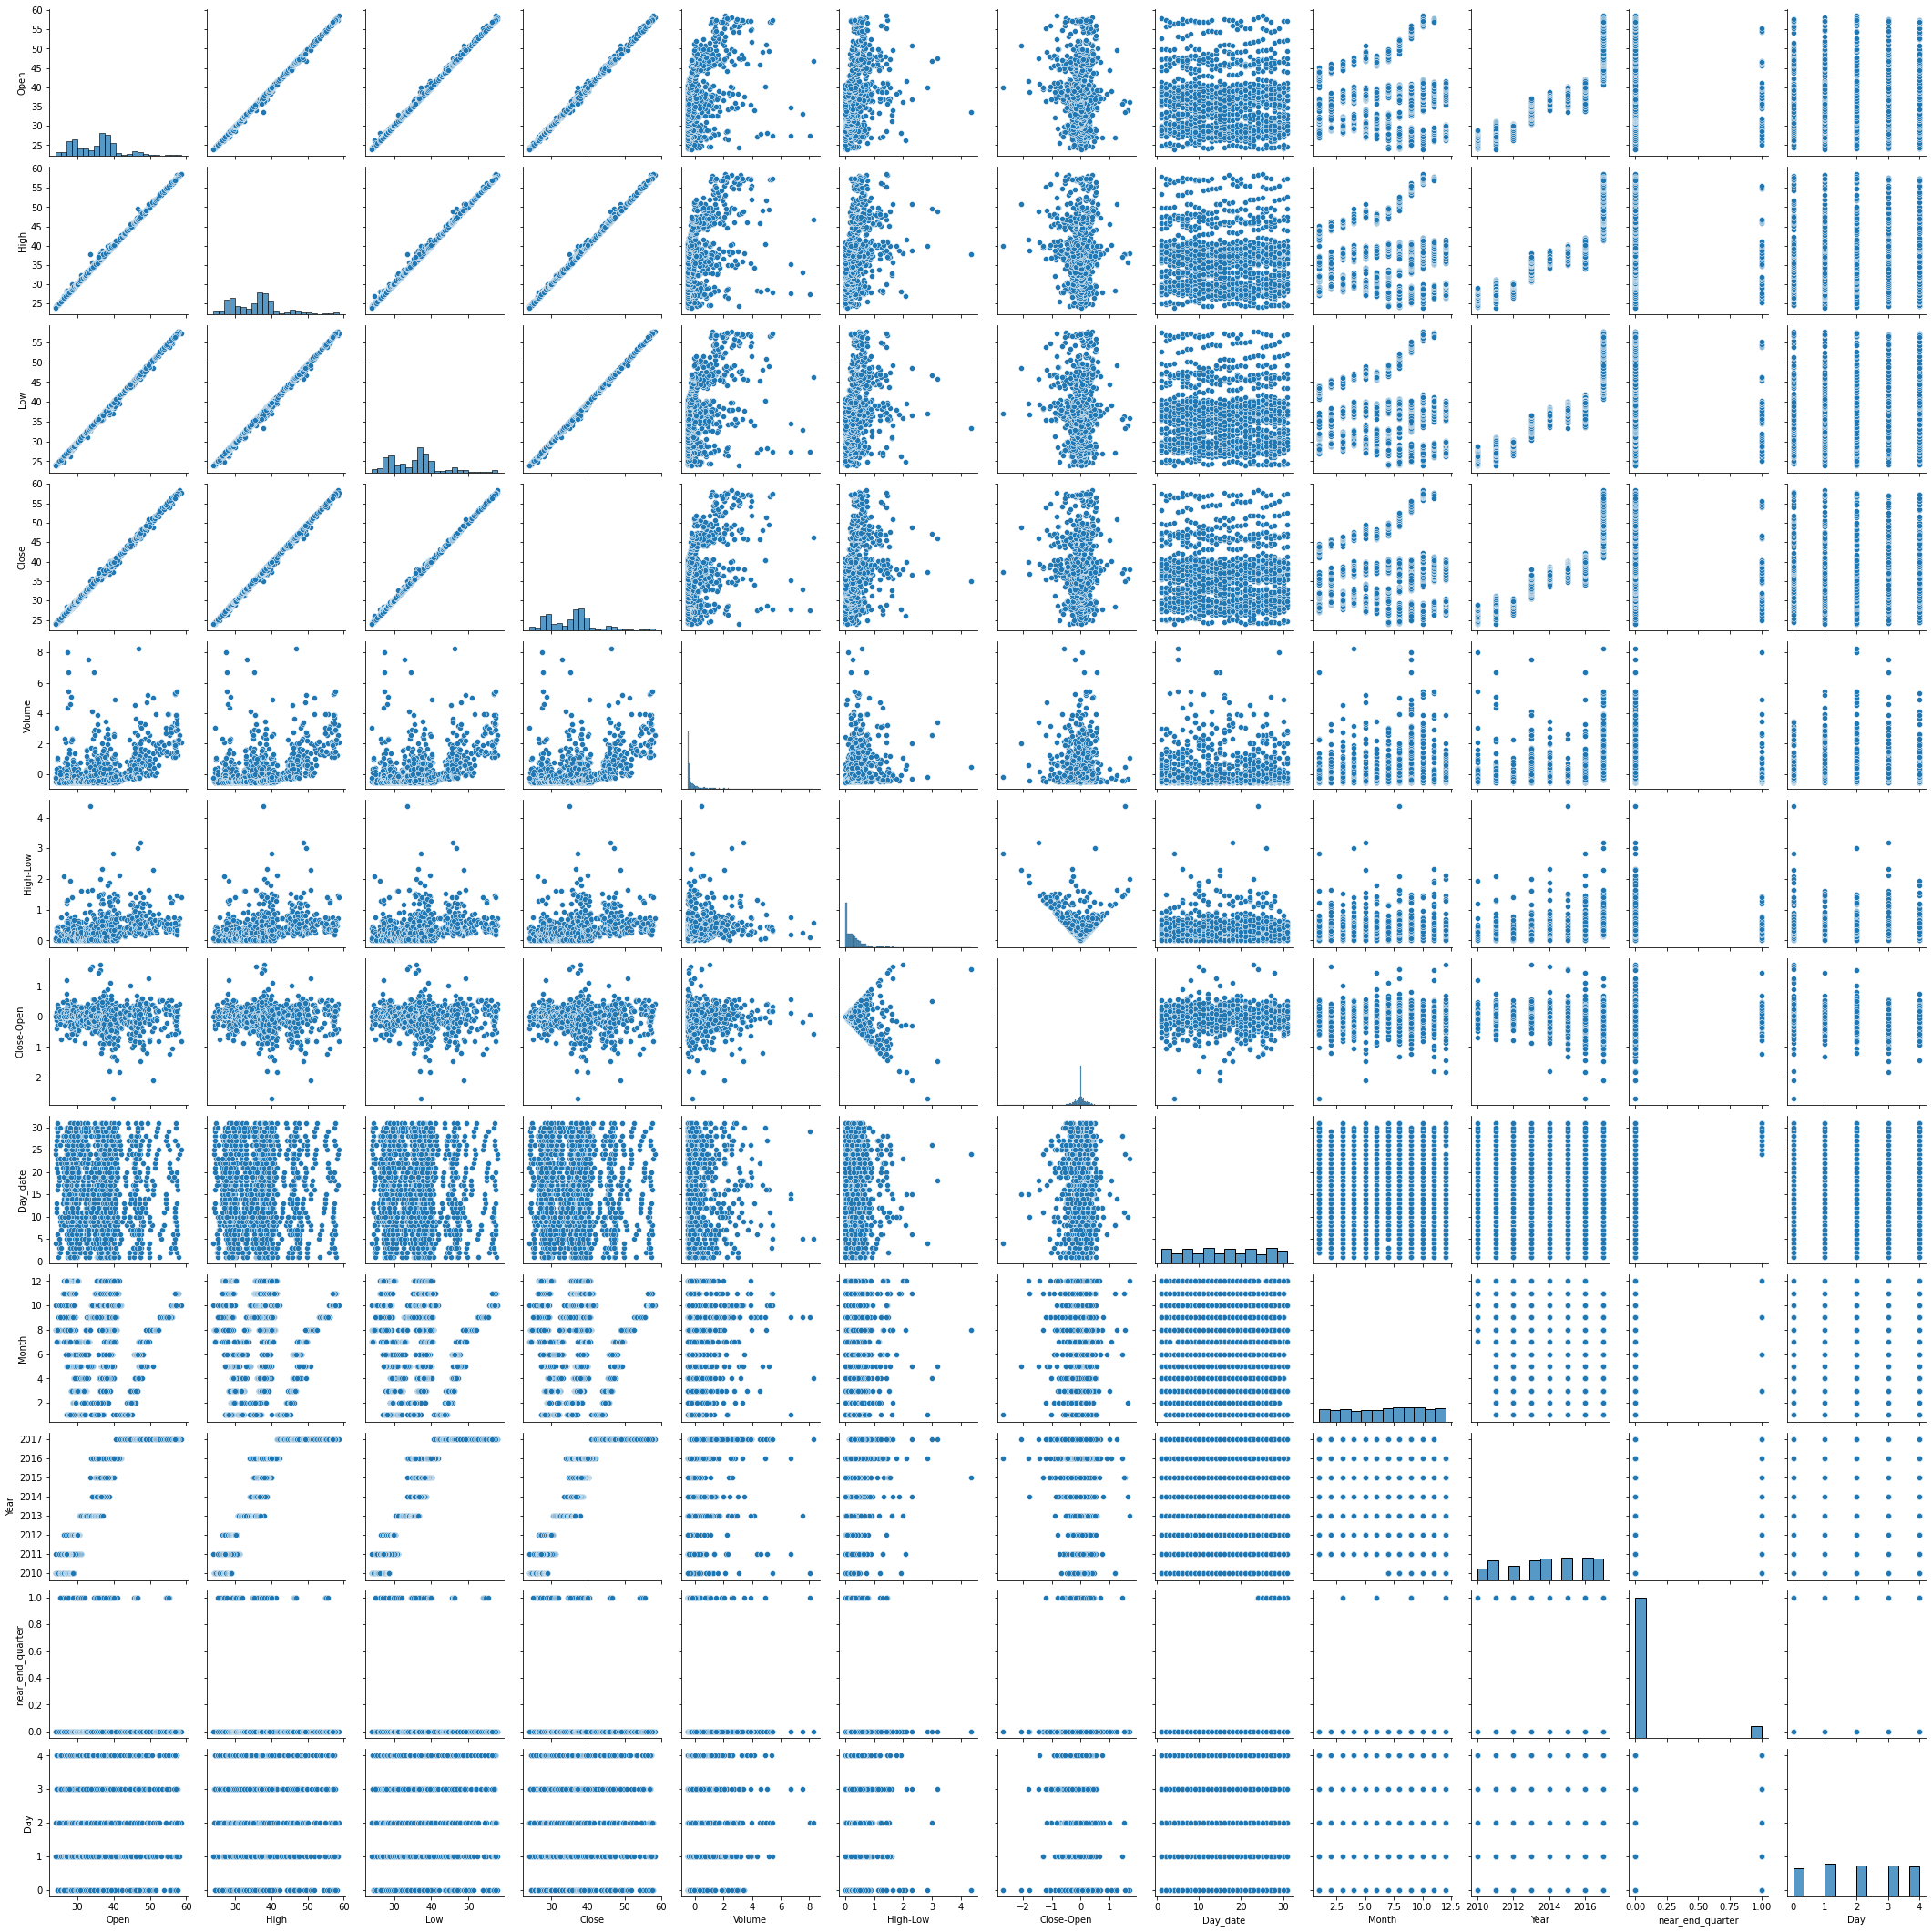

In [105]:
X_train, X_test, T_train, T_test = market_prepro(f,st,sn)